In [20]:
#import libraries
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import date
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import power_transform

In [21]:
#import data
base_dir = '/Users/trozmus/Documents/development/AICoursera4/ai-workflow-capstone/assigment'
file_path = os.path.join(base_dir,"data","cs-train","ts-data","ts-eire.csv")
ts_all = pd.read_csv(file_path,parse_dates=['date'],index_col='date')

In [22]:
ts_rev_all = ts_all[['revenue']]

In [23]:
ts_rev_all.shape

(607, 1)

<ipython-input-24-a3313431c6da>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(ts_rev_all.revenue.dropna(),freq=30)


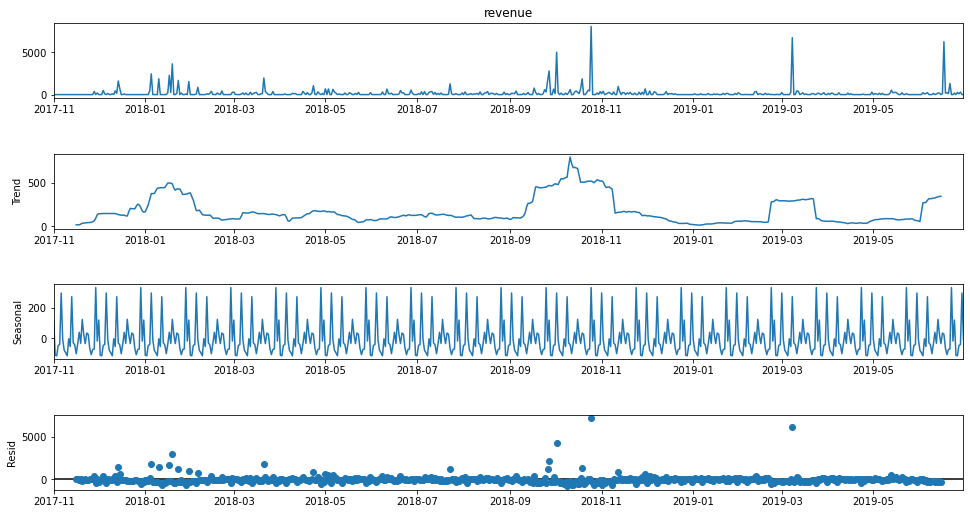

In [24]:
res = sm.tsa.seasonal_decompose(ts_rev_all.revenue.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [25]:
train_start,train_end = '2017-11-01','2019-03-31'
test_start,test_end = '2019-04-01','2019-06-30'
train = ts_rev_all['revenue'][train_start:train_end].dropna()
test = ts_rev_all['revenue'][test_start:test_end].dropna()

In [26]:
train.shape, test.shape

((516,), (91,))

In [27]:
from statsmodels.tsa.stattools import adfuller

#ts_rev_all=ts_rev_all.resample('date')

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    

    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    #plt.grid(True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.xticks()
    plt.show()    

    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

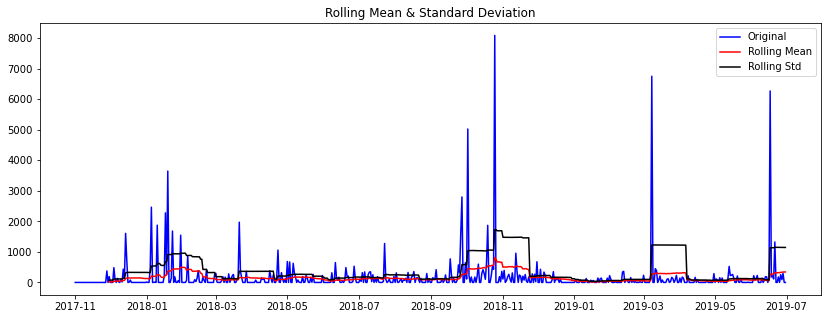

<Results of Dickey-Fuller Test>
Test Statistic                 -23.724901
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64


In [28]:
test_stationarity(ts_rev_all.revenue.dropna())

In [29]:
ts_rev_all['log_revenue']=np.log(ts_rev_all['revenue'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-29-ce34b239706a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_rev_all['log_revenue']=np.log(ts_rev_all['revenue'])


In [30]:
ts_rev_all.head()

,revenue,log_revenue
date,,
2017-11-01,0.0,-inf
2017-11-02,0.0,-inf
2017-11-03,0.0,-inf
2017-11-04,0.0,-inf
2017-11-05,0.0,-inf


In [31]:
ts_rev_new = ts_rev_all.replace([np.inf, -np.inf], np.nan)

In [32]:
ts_rev_new.head()

,revenue,log_revenue
date,,
2017-11-01,0.0,NaN
2017-11-02,0.0,NaN
2017-11-03,0.0,NaN
2017-11-04,0.0,NaN
2017-11-05,0.0,NaN


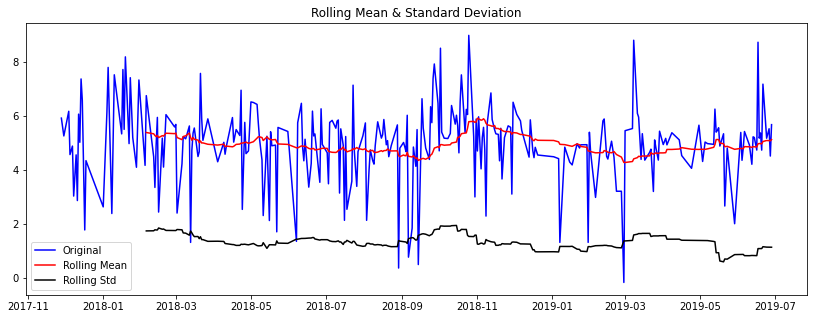

<Results of Dickey-Fuller Test>
Test Statistic                -6.955054e+00
p-value                        9.475856e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.770000e+02
Critical Value (1%)           -3.454180e+00
Critical Value (5%)           -2.872031e+00
Critical Value (10%)          -2.572360e+00
dtype: float64


In [33]:
test_stationarity(ts_rev_new['log_revenue'].dropna())

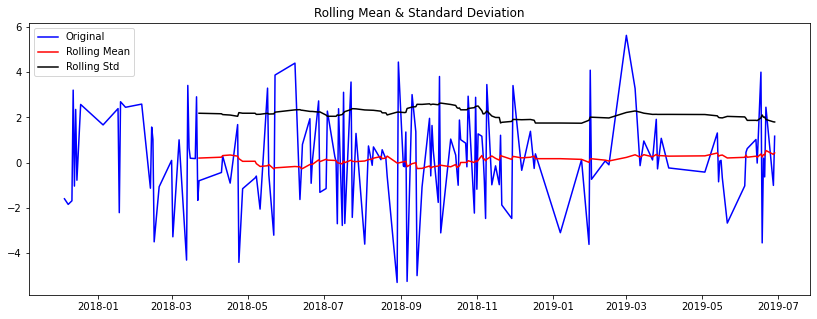

<Results of Dickey-Fuller Test>
Test Statistic                -1.722423e+01
p-value                        6.251672e-30
#Lags Used                     0.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [34]:
test_stationarity(ts_rev_new['log_revenue'].diff(1).dropna())
#test_stationarity(df1[‘log_Spend’].diff(1).dropna())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


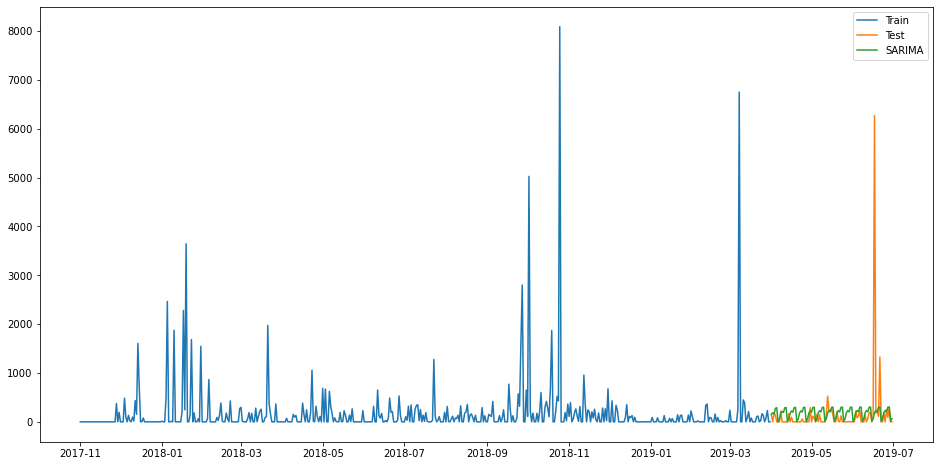

In [35]:
import statsmodels.api as sm
fit1 = sm.tsa.statespace.SARIMAX(train, order=(7, 1, 2), seasonal_order=(0, 1, 2, 7)).fit(disp=False)
#pred = fit1.predict(start='2019-06-01', end='2019-06-30', dynamic=True)[1:]
pred = fit1.predict(train_end, test_end, dynamic=True)[1:]
plt.figure(figsize=(16, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [36]:
#calculate mse and mae
print('Model MSE:{}'.format(mean_squared_error(test,pred)))
print('Model MAE:{}'.format(mean_absolute_error(test,pred)))

Model MSE:444398.83814929007
Model MAE:205.08777224616793
